# Runner example

This notebook will go through the options of the runner class. We will show how to fit and evaluate a model in parallel, and how to do cross-validation. 

This notebook is based off the blr_example notebook, and it is recommended to follow that notebook first.


### Imports

In [1]:
import pandas as pd
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_blr import NormBLR
from pcntoolkit.regression_model.blr.blr_conf import BLRConf
from pcntoolkit.util.runner import Runner
from pcntoolkit.util.plotter import plot_centiles, plot_qq

# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [2]:
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)
data = pd.read_csv("resources/data/fcon1000.csv")
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=["age"],
    batch_effects=["sex", "site"],
    response_vars=["rh_MeanThickness_thickness", "WM-hypointensities"],
)

# Leave two sites out for doing transfer and extend later
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects(
    {"site": transfer_sites}, names=("transfer", "fit")
)

# Split into train and test sets
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. 

Our `NormConf` object configures:
- a save path paths and whether to save the model and results
- a standardization step for both the covariates (inscaler) and the response vars (outscaler)
- a Bspline basis expansion of order 3 with 5 knots

In [3]:
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir="resources/blr/save_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="bspline",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

Configuration of normative model is valid.


## Configure the regression model


In [4]:
blr_conf = BLRConf(
    optimizer="l-bfgs-b",
    n_iter=1000,
    heteroskedastic=True,
    random_intercept=True,
    random_intercept_var=True,
    warp="WarpSinhArcsinh",
    warp_reparam=True,
)

Configuration of regression model is valid.


## Combine normative and blr conf in normative model
We can either use the NormBLR constructor, or the factory method to create a normative BLR model

In [5]:
# Using the constructor
norm_blr = NormBLR(norm_conf=norm_conf, reg_conf=blr_conf)

## Fit the model
Normally we would just call 'fit_predict' on the model directly, but because we want to use the runner to do cross-validation in parallel, we need to first create a runner object. 

In [6]:
runner = Runner(
    cross_validate=True,
    cv_folds=10,
    parallelize=True,
    job_type="local",  # or "slurm" if you are on a slurm cluster
    n_jobs=2,
    log_dir="resources/blr_kfold/log_dir",
    temp_dir="resources/blr_kfold/temp_dir",
)

No python path specified. Using interpreter path of current process: /opt/anaconda3/envs/dev_refactor/bin/python


The runner object will now fit the model in parallel, and save the results in save directories that it will create for each fold.

In [7]:
runner.fit_predict(norm_blr, train)

/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Going to fit and predict 1 models
Fitting and predicting model for rh_MeanThickness_thickness


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities
32653 Saving model to resources/blr/save_dir/folds/fold_0
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_0/model
Computing zscores for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.08402e-16): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.07766e-16): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.06201e-16): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/

Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_0/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_0/plots
32653 Saving model to resources/blr/save_dir/folds/fold_0
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_0/model
Going to fit and predict 1 models
Fitting and predicting model for rh_MeanThickness_thickness
32654 Saving model to resources/blr/save_dir/folds/fold_0
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_0/model
Computing zscores for WM-hypointensities
Computing centiles for WM-hypointensities
Computing centiles for WM-hypointensities


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_0/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_0/plots
32654 Saving model to resources/blr/save_dir/folds/fold_0
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_0/model
Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/warp.py:522: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.35199e-18): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=8.07794e-19): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=2.86767e-19): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_r

32653 Saving model to resources/blr/save_dir/folds/fold_1
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_1/model
Computing zscores for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_1/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_1/plots
32653 Saving model to resources/blr/save_dir/folds/fold_1
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_1/model
Going to fit and predict 1 models
Fitting and predicting model for rh_MeanThickness_thickness
32654 Saving model to resources/blr/save_dir/folds/fold_1
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fol

/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_1/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_1/plots
32654 Saving model to resources/blr/save_dir/folds/fold_1
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_1/model
Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities
32654 Saving model to resources/blr/save_dir/folds/fold_2
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_2/model
Computing zscores for WM-hypointensities
Computing centiles for WM-hypointensities
Computing centiles for WM-hypointensities


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_2/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_2/plots
32654 Saving model to resources/blr/save_dir/folds/fold_2
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_2/model
Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/warp.py:522: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=6.75358e-19): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=3.7836e-18): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.3975e-18): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_ref

32653 Saving model to resources/blr/save_dir/folds/fold_2
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_2/model
Computing zscores for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_2/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_2/plots
32653 Saving model to resources/blr/save_dir/folds/fold_2
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_2/model
Going to fit and predict 1 models
Fitting and predicting model for rh_MeanThickness_thickness


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=6.38167e-17): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=6.68807e-17): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=7.81702e-17): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=6.78507e-17): result may not be accurate.
  invAXt: np.ndarray 

32654 Saving model to resources/blr/save_dir/folds/fold_3
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_3/model
Computing zscores for WM-hypointensities
Computing centiles for WM-hypointensities
Computing centiles for WM-hypointensities


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/warp.py:522: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=6.22442e-19): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.01384e-18): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regre

Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_3/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_3/plots
32654 Saving model to resources/blr/save_dir/folds/fold_3
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_3/model
32653 Saving model to resources/blr/save_dir/folds/fold_3
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_3/model
Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities
Computing zscores for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_3/results and /Users/stijndeboer/Projects/PCN/PCNtoo

/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_4/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_4/plots
32653 Saving model to resources/blr/save_dir/folds/fold_4
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_4/model
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_4/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_4/plots
32654 Saving model to resources/blr/save_dir/folds/fold_4
Going to fit and predict 1 models
Fitting and predicting model for rh_MeanThickness_thickness
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_4/model
Going to fit and predict 1 models
Fitting and predicting model for WM-hypoin

/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/warp.py:522: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.94687e-19): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=2.09533e-18): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regre


Computing zscores for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_5/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_5/plots
32654 Saving model to resources/blr/save_dir/folds/fold_5
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_5/model
Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_5/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_5/plots
32653 Saving model to resources/blr/save_dir/folds/fold_5
Model saved to /Users/stijndeboer/Projects/PCN/PCNto

/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.10339e-16): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.00051e-16): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=4.96241e-17): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=5.33788e-17): result may not be accurate.
  invAXt: np.ndarray 

32654 Saving model to resources/blr/save_dir/folds/fold_6
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_6/model
Computing zscores for WM-hypointensities
Computing centiles for WM-hypointensities
Computing centiles for WM-hypointensities
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_6/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_6/plots
32654 Saving model to resources/blr/save_dir/folds/fold_6
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_6/model
Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities
32653 Saving model to resources/blr/save_dir/folds/fold_6
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_6/model
Computing zscores for 

/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


32654 Saving model to resources/blr/save_dir/folds/fold_7
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_7/model
Computing zscores for WM-hypointensities
Computing centiles for WM-hypointensities
Computing centiles for WM-hypointensities


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_7/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_7/plots
32654 Saving model to resources/blr/save_dir/folds/fold_7
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_7/model
Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities
32653 Saving model to resources/blr/save_dir/folds/fold_7
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_7/model
Computing zscores for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_7/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_7/plots
32653 Saving model to resources/blr/save_dir/folds/fold_7
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_7/model
Going to fit and predict 1 models
Fitting and predicting model for rh_MeanThickness_thickness


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:282: RuntimeWarning: divide by zero encountered in divide
  beta = beta/(delta**2)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=9.55006e-19): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=6.83701e-19): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:619: RuntimeWarning: overflow encountered in divide
  J_transposed[i] = df / dx
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Il

32654 Saving model to resources/blr/save_dir/folds/fold_8
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_8/model
Computing zscores for WM-hypointensities
Computing centiles for WM-hypointensities
Computing centiles for WM-hypointensities
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_8/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_8/plots
32654 Saving model to resources/blr/save_dir/folds/fold_8
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_8/model
Going to fit and predict 1 models
Fitting and predicting model for WM-hypointensities


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/warp.py:522: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.65345e-18): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/warp.py:560: RuntimeWarning: overflow encountered in cosh
  dx = (b * np.cosh(b * np.arcsinh(x) - a)) / np.sqrt(1 + x**2)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.30238e-19): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolki

32653 Saving model to resources/blr/save_dir/folds/fold_8
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_8/model
Computing zscores for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_8/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_8/plots
32653 Saving model to resources/blr/save_dir/folds/fold_8
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_8/model
Going to fit and predict 1 models
Fitting and predicting model for rh_MeanThickness_thickness


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:282: RuntimeWarning: divide by zero encountered in divide
  beta = beta/(delta**2)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/warp.py:522: RuntimeWarning: overflow encountered in sinh
  y = np.sinh(b * np.arcsinh(x) - a)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcond=1.47674e-21): result may not be accurate.
  invAXt: np.ndarray = linalg.solve(self.A, X.T, check_finite=False)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/warp.py:560: RuntimeWarning: overflow encountered in cosh
  dx = (b * np.cosh(b * np.arcsinh(x) - a)) / np.sqrt(1 + x**2)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/regression_model/blr/blr.py:343: LinAlgWarning: Ill-conditioned matrix (rcon

32653 Saving model to resources/blr/save_dir/folds/fold_9
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_9/model
Computing zscores for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
Computing centiles for rh_MeanThickness_thickness
32654 Saving model to resources/blr/save_dir/folds/fold_9
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_9/model
Computing zscores for WM-hypointensities
Computing centiles for WM-hypointensities
Computing centiles for WM-hypointensities
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_9/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_9/plots
32653 Saving model to resources/blr/save_dir/folds/fold_9
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/r

/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_9/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_9/plots
32654 Saving model to resources/blr/save_dir/folds/fold_9
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_9/model

All jobs completed!


### Loading a fold model
We can load a model for a specific fold by calling `load_fold_model` on the runner object. This will return a `NormBLR` object, which we can inspect and use to predict on new data.


In [8]:
fold_model = runner.load_fold_model(0)
fold_model.predict(test)

display(fold_model)

Configuration of normative model is valid.
Configuration of normative model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Going to predict 2 models
Predicting model for rh_MeanThickness_thickness
Predicting model for WM-hypointensities
Computing zscores for rh_MeanThickness_thickness
Computing zscores for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_0/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/blr/save_dir/folds/fold_0/plots


## Inspecting the model 

The norm_blr model contains a collection of regression models, one for each response variable. We can inspect those models individually by calling `norm_blr.regression_models.get("{responsevar}")`

In [9]:
model = fold_model.regression_models.get("rh_MeanThickness_thickness")  # type: ignore
model.__dict__

{'_name': 'rh_MeanThickness_thickness',
 '_reg_conf': BLRConf(n_iter=1000, tol=1e-05, ard=False, optimizer='l-bfgs-b', l_bfgs_b_l=0.1, l_bfgs_b_epsilon=0.1, l_bfgs_b_norm='l2', intercept=False, random_intercept=True, heteroskedastic=True, intercept_var=False, random_intercept_var=True, warp='WarpSinhArcsinh', warp_reparam=True),
 'is_fitted': True,
 '_is_from_dict': True,
 'hyp': array([-7.98846121e-03,  3.19939145e-01,  7.11195200e-01,  2.58949745e-01,
        -2.88577058e-02, -5.91439943e-02, -7.14464414e-03,  4.72354122e-01,
         5.80013512e-01,  1.58141055e-02,  7.50597427e-02,  1.82371592e-02,
         1.68802417e-03,  4.29198828e-02,  2.53382957e-01,  1.06291257e-01,
         4.27580740e-01, -2.35446219e-02, -1.10923000e-01,  6.13226420e-02,
         3.84082683e-02, -6.88920694e-03,  1.24636229e-01,  3.17463513e-02,
         5.63562904e-02,  1.42691806e-02, -3.58819435e-02,  1.35507330e-03,
        -3.95532312e-02, -7.17498583e-03, -4.86411274e-01, -2.55170610e-01,
        -1

## Evaluation
Calling `predict` will extend the predict_data object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [10]:
display(test.measures.to_pandas().T)


response_vars,rh_MeanThickness_thickness,WM-hypointensities
statistics,,
Rho,0.555718,0.558820
RMSE,0.078081,534.101204
SMSE,0.682714,0.633821
ExpV,0.334615,0.383654
NLL,NaN,NaN
ShapiroW,0.977854,0.993941


Datasets with a zscores DataArray will have the `.plot_qq()` function available:

In [11]:
display(test.zscores.to_pandas())  # the zscores

response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
515,-1.439253,-0.369922
441,-1.041670,-0.699890
1029,0.980233,0.877266
64,-2.536797,0.442108
654,1.013305,-1.819039
...,...,...
611,-1.438304,2.129770
549,-1.468916,2.383562
640,0.234414,-2.003428


In [12]:
display(test.centiles.to_dataframe().unstack(level=["response_vars", "cdf"]))

centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
515                             2.446909         861.706225   
441                             2.445264         996.919679   
1029                            2.466307         599.984473   
64                              2.346867         561.672483   
654                             2.331738         609.803798   
...                                  ...                ...   
611                             2.358473         742.205413   
549                             2.229071         707.149099   
640                             2.248933         900.221587   
648                             2.388047         741.647290   
635                             2.498333         510.593780   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
515                             2.492986        1050.943437   
441                             2.487536        1180.021093   
1029                            2.528709         819.774953   
64                              2.400730         775.181279   
654                             2.401821         951.112641   
...                                  ...                ...   
611                             2.422868        1065.446826   
549                             2.303618        1005.198073   
640                             2.329877        1321.571642   
648                             2.446231        1022.154710   
635                             2.572270         764.562926   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.50               0.50   
datapoints                                                    
515                             2.529192        1191.860756   
441                             2.520140        1319.762007   
1029                            2.582606         977.682098   
64                              2.437405         927.414418   
654                             2.449355        1210.623735   
...                                  ...                ...   
611                             2.467736        1319.739596   
549                             2.352716        1232.854769   
640                             2.382927        1715.236722   
648                             2.488429        1236.278469   
635                             2.638067         946.177162   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.75               0.75   
datapoints                                                    
515                             2.571355        1346.191342   
441                             2.557426        1476.306211   
1029                            2.648185        1144.928248   
64                              2.475004        1086.869092   
654                             2.499828        1522.639478   
...                                  ...                ...   
611                             2.517201        1636.175458   
549                             2.399872        1501.672439   
640                             2.434318        2353.028304   
648                             2.536697        1486.624936   
635                             2.716134        1139.002257   

                                                             
response_vars rh_MeanThickness_thickness WM-hypointensities  
cdf                                 0.95               0.95  
datapoints                                                   


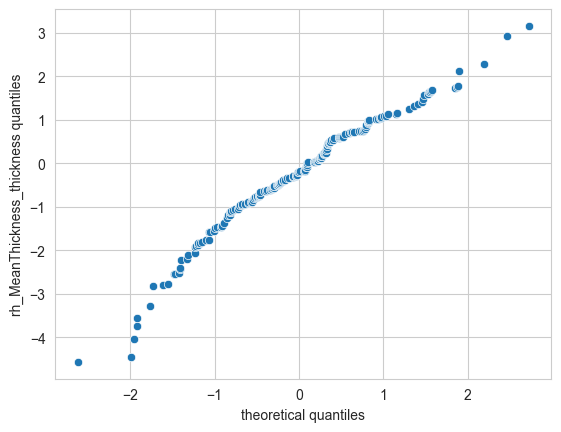

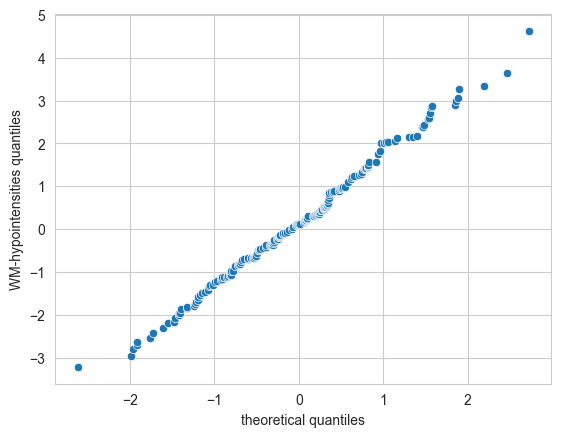

In [13]:
plot_qq(test)

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`train` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.25, 0.5, 0.75, 0.95]. It is also possible to pass a list of CDF values to plot.

It may seem strange that the centiles do not match the plotted data, but that is because the centiles are calculated for a single batch effect, and it is superimposed on the full dataset. The blue markers correspond to the data for which the centiles are calculated. 

Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


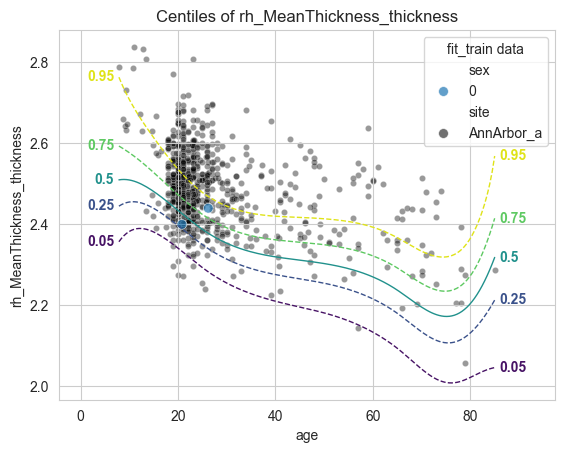

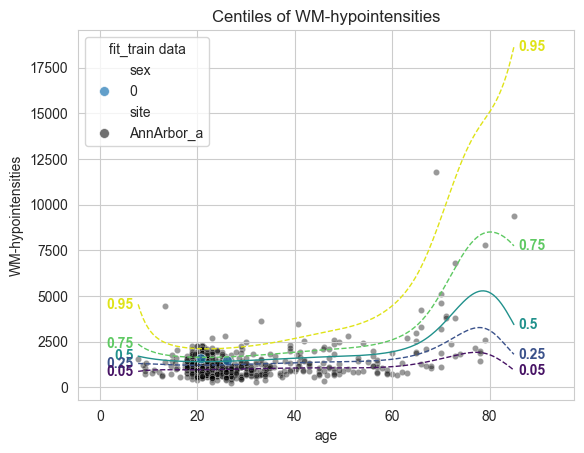

In [14]:
plot_centiles(
    fold_model,
    train,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
)

The values of 0.1587 and 0.8413 correspond to a standard deviation of -1 and 1. We plot the centiles again for these values, and we also highlight a specific site. 


Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


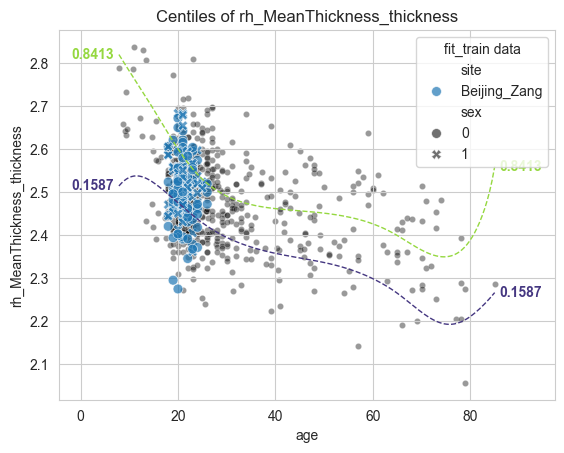

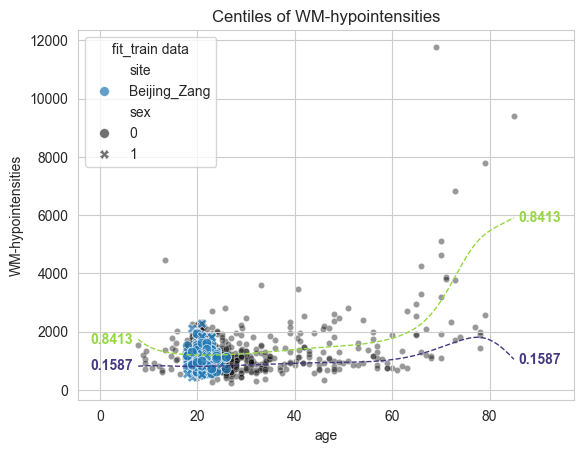

In [15]:
plot_centiles(
    fold_model,
    train,
    covariate="age",
    cummul_densities=[0.1587, 0.8413],
    show_data=True,
    batch_effects={"site": ["Beijing_Zang"]},
)

# Transfering with the runner

The runner can also be used to transfer or extenda model to a new dataset. This is done by calling `transfer` on the runner object. This will transfer the model to the new dataset, and save the transfered model in the save directory.

runner.transfer(transfer_train, transfer_test)

Let's first fit an HBR model, and then transfer it to the transfer dataset.



In [15]:
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.param import make_param


mu = make_param(
    name="mu",
    linear=True,
    slope=make_param(dist_name="Normal", dist_params=(0.0, 5.0)),
    intercept=make_param(
        random=True,
        sigma=make_param(dist_name="HalfNormal", dist_params=(1.0,)),
        mu=make_param(dist_name="Normal", dist_params=(0.0, 0.5)),
    ),
)
sigma = make_param(
    name="sigma",
    linear=True,
    slope=make_param(dist_name="Normal", dist_params=(0.0, 3.0)),
    intercept=make_param(
        dist_name="Normal",
        dist_params=(
            1.0,
            1.0,
        ),
    ),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
)

# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=2048,
    tune=512,
    chains=4,
    pymc_cores=16,
    likelihood="Normal",
    mu=mu,
    sigma=sigma,
    nuts_sampler="nutpie",
)
save_dir = "resources/hbr_transfer_runner/save_dir"

norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir="resources/hbr_transfer_runner/save_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="bspline",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

norm_hbr = NormHBR(norm_conf=norm_conf, reg_conf=hbr_conf)

runner = Runner(
    cross_validate=False,
    parallelize=True,
    job_type="local",  # or "slurm" if you are on a slurm cluster
    n_jobs=2,
    log_dir="resources/hbr_transfer_runner/log_dir",
    temp_dir="resources/hbr_transfer_runner/temp_dir",
)

runner.fit_predict(norm_hbr, train, test)

to_transfer = NormHBR.load("resources/hbr_transfer_runner/save_dir")

Configuration of normative model is valid.


Now we use the runner to transfer the model to the transfer dataset.


In [16]:
runner.transfer_predict(to_transfer, transfer_train, transfer_test)


Going to transfer 2 models
Transferring model for rh_MeanThickness_thickness
Going to transfer 2 models
Transferring model for WM-hypointensities
Configuration of normative model is valid.
33448 Saving model to resources/hbr_transfer_runner/save_dir_transfer
Configuration of normative model is valid.
33447 Saving model to resources/hbr_transfer_runner/save_dir_transfer
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_transfer/model
Going to predict 1 models
Predicting model for WM-hypointensities
Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:-- / 0:00:00Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_transfer/model
Going to predict 1 models
Predicting model for rh_MeanThickness_thickness
Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:-- / 0:00:00/ 0:00:00

Sampling: [y_pred]
Sampling: [y_pred]


Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00/ 0:00:00
Computing zscores for WM-hypointensities
Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━  74% 0:00:01 / 0:00:00

Sampling: [y_pred]
Sampling: [y_pred]


Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00
Computing zscores for rh_MeanThickness_thickness
Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00/ 0:00:00
Computing centiles for WM-hypointensities
Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00/ 0:00:00
Computing centiles for rh_MeanThickness_thickness
Sampling ... ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━  38% 0:00:01 / 0:00:00

Sampling: [y_pred]
Sampling: [y_pred]


Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00/ 0:00:00
Computing centiles for WM-hypointensities


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = stats.spearmanr(y, yhat)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = stats.spearmanr(y, yhat)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00/ 0:00:00
Computing centiles for rh_MeanThickness_thickness
Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00/ 0:00:00
Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:0000:0000:00
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_transfer/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_transfer/plots
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_transfer/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_transfer/plots

All jobs completed!


And that's it, now you have seen how to:
- Use the runner to do cross-validation in parallel
- Inspect the model of a specific fold
- Evaluate the model on a test set
- Create useful plots

We hope this tutorial was useful. If you have any questions or remarks, please let us know on GitHub. Thanks!


In [17]:
to_transfer.predict(transfer_test)
original_model = NormHBR.load("resources/hbr_transfer_runner/save_dir")
try:
    original_model.predict(transfer_test)
except Exception as e:
    print(e)


Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [site_offset_intercept_mu, y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [site_offset_intercept_mu, y_pred]


Output()

Computing zscores for rh_MeanThickness_thickness


Sampling: [site_offset_intercept_mu, y_pred]


Output()

Computing zscores for WM-hypointensities


Sampling: [site_offset_intercept_mu, y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [site_offset_intercept_mu, y_pred]


Output()

Computing centiles for WM-hypointensities


Sampling: [site_offset_intercept_mu, y_pred]


Output()

/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Computing centiles for rh_MeanThickness_thickness


Sampling: [site_offset_intercept_mu, y_pred]


Output()

Computing centiles for WM-hypointensities


Sampling: [site_offset_intercept_mu, y_pred]


Output()

Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir/plots
Configuration of normative model is valid.
Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [site_offset_intercept_mu, y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [site_offset_intercept_mu, y_pred]


Output()

Computing zscores for rh_MeanThickness_thickness


Sampling: [site_offset_intercept_mu, y_pred]


Output()

Computing zscores for WM-hypointensities


Sampling: [site_offset_intercept_mu, y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [site_offset_intercept_mu, y_pred]


Output()

Computing centiles for WM-hypointensities


Sampling: [site_offset_intercept_mu, y_pred]


Output()

/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Computing centiles for rh_MeanThickness_thickness


Sampling: [site_offset_intercept_mu, y_pred]


Output()

Computing centiles for WM-hypointensities


Sampling: [site_offset_intercept_mu, y_pred]


Output()

Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir/plots
